# Poisson's relation

This code illustrates the Poisson's relation by using rectangular prisms.

### Things we have to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gravmag.models import rectangular_prism as rp
from gravmag import constants as cts
from gravmag import plot_functions as plf

### Model

In [2]:
# Create a model formed by prisms
model = np.array([[2000., 3000., -1500., -500., 10., 1010.], 
                  [1600., 2600., -2500., -1500., 10., 1010.], 
                  [-10000., 10000., 1500., 2500., 10., 1010.],
                  [-3000., -2000., -10000., 1500., 10., 1010.]])

# magnetization of each prism
# first, second and third columns contain
# the magnetization intensity (in A/m), inclination 
# and declination (in degrees) of the sources
h, inc, dec = 1.3, 30, -45
magnetization = np.array([[h, inc, dec],
                          [h, inc, dec],
                          [h, inc, dec],
                          [h, inc, dec]])

# Cartesian component of magnetization
cos_inc = np.cos(np.deg2rad(inc))
sin_inc = np.sin(np.deg2rad(inc))
cos_dec = np.cos(np.deg2rad(dec))
sin_dec = np.sin(np.deg2rad(dec))
hx_hat = cos_inc*cos_dec
hy_hat = cos_inc*sin_dec
hz_hat = sin_inc

# density of each prism (in kg/m³)
rho = 900
density = np.zeros(4)+rho

### Points were we compute the synthetic data

In [3]:
# number of points along x and y
shape = (100, 100)

# minimum x, maximum x, minimum y and maximum y
area = [-5000, 5000, -4000, 6000]

# coordinates 
xp = np.linspace(area[0], area[1], shape[0])
yp = np.linspace(area[2], area[3], shape[1])
yp, xp = np.meshgrid(yp, xp)
yp = np.ravel(yp)
xp = np.ravel(xp)
zp = np.zeros_like(yp) - 150

coordinates = np.vstack([xp, yp, zp])

### Main field

In [4]:
# reference point
yc, xc = 0, 1000

# polynomial function defining the inclination (degrees)
I0 = 60 - 1e-4*(xp-xc) + 3e-4*(yp-yc) + 1e-8*(xp-xc)*(xp-xc) + 1e-8*(yp-yc)*(yp-yc)

# polynomial function defining the declination (degrees)
D0 = -43 + 6e-5*(xp-xc) + 1e-4*(yp-yc) + 3e-9*(xp-xc)*(xp-xc) + 4e-9*(yp-yc)*(yp-yc)

# polynomial function defining the intensity (nT)
F0 = 23400 + 1e-4*(xp-xc) + 1e-4*(yp-yc) + 0*(xp-xc)*(xp-xc) + 0*(yp-yc)*(yp-yc)

# Cartesian components of the main field
cosI0 = np.cos(np.deg2rad(I0))
sinI0 = np.sin(np.deg2rad(I0))
cosD0 = np.cos(np.deg2rad(D0))
sinD0 = np.sin(np.deg2rad(D0))
Fx = F0*cosI0*cosD0
Fy = F0*cosI0*sinD0
Fz = F0*sinI0

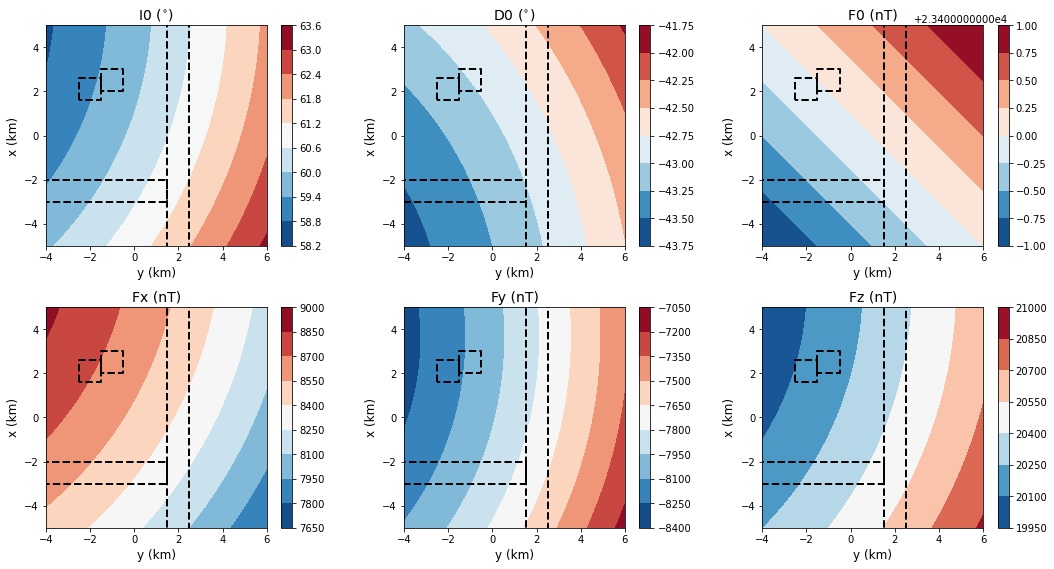

In [5]:
fields = [I0, D0, F0, Fx, Fy, Fz]
windows = [1, 2, 3, 4, 5, 6]
titles = ['I0 ($^{\circ}$)', 'D0 ($^{\circ}$)', 'F0 (nT)',
          'Fx (nT)', 'Fy (nT)', 'Fz (nT)']

plt.figure(figsize=(15,8))

for w, window in enumerate(windows):

    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Synthetic data

In [6]:
# Compute the scaler magnetic potential
V = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_potential')

# Compute the magnetic field components
bx = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_x')
by = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_y')
bz = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_z')

# Compute the acceleration components
gx = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_x')
gy = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_y')
gz = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_z')

# Compute the second derivatives
gxx = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_xx')
gxy = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_xy')
gxz = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_xz')
gyy = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_yy')
gyz = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_yz')
gzz = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_zz')

In [7]:
Poisson_ratio = (cts.CM*h)/(cts.GRAVITATIONAL_CONST*rho)
V_Poisson = -(cts.T2MT/cts.SI2MGAL)*Poisson_ratio*(hx_hat*gx + hy_hat*gy + hz_hat*gz)
bx_Poisson = (cts.T2NT/cts.SI2EOTVOS)*Poisson_ratio*(hx_hat*gxx + hy_hat*gxy + hz_hat*gxz)
by_Poisson = (cts.T2NT/cts.SI2EOTVOS)*Poisson_ratio*(hx_hat*gxy + hy_hat*gyy + hz_hat*gyz)
bz_Poisson = (cts.T2NT/cts.SI2EOTVOS)*Poisson_ratio*(hx_hat*gxz + hy_hat*gyz + hz_hat*gzz)

diff_V = V_Poisson - V
diff_bx = bx_Poisson - bx
diff_by = by_Poisson - by
diff_bz = bz_Poisson - bz

### Plot the data

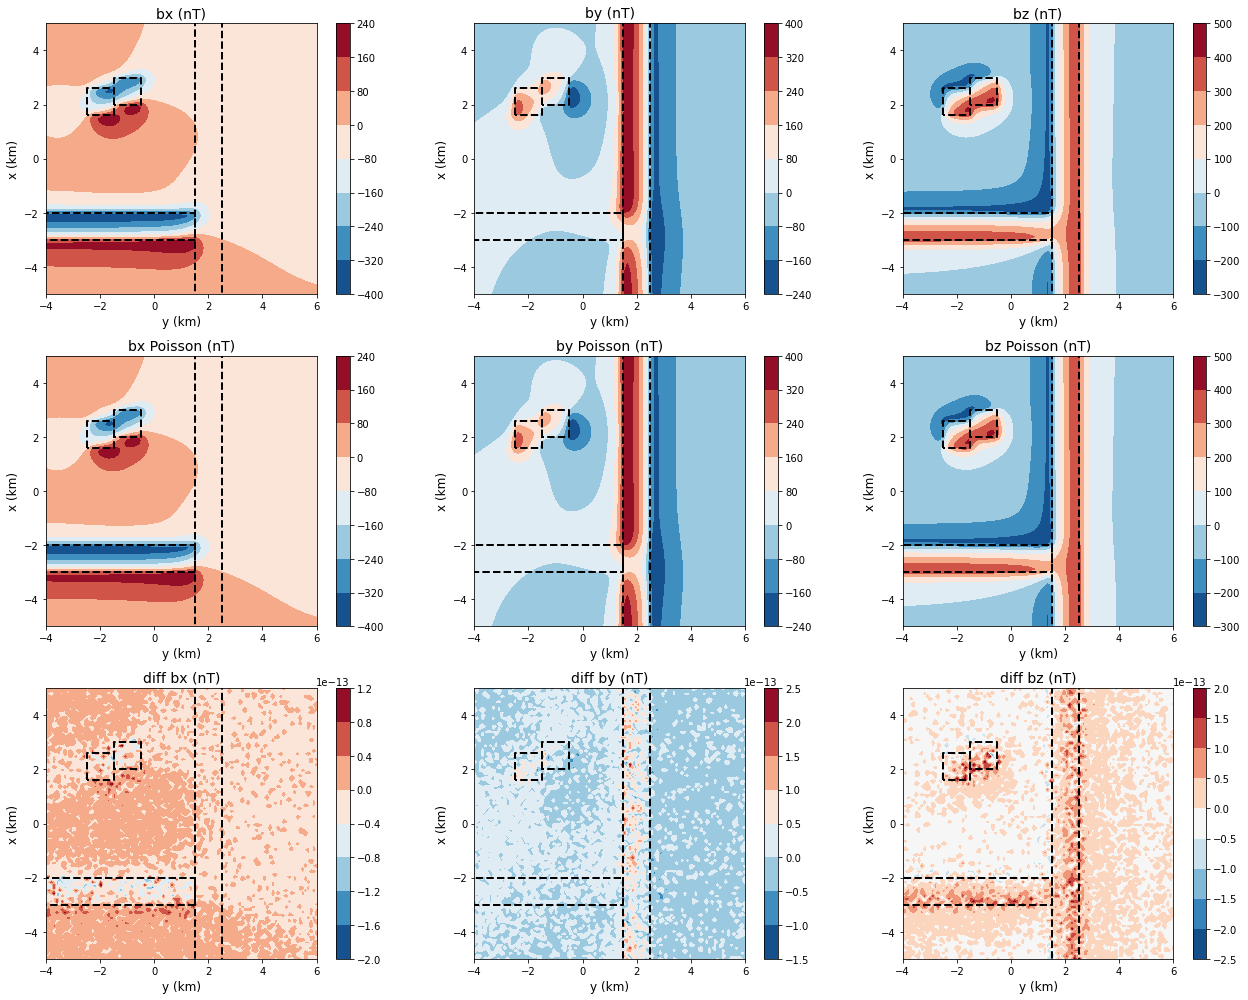

In [8]:
fields = [bx, by, bz, 
          bx_Poisson, by_Poisson, bz_Poisson,
          diff_bx, diff_by, diff_bz]
windows = [1, 2, 3, 4, 5, 6, 7, 8, 9]
titles = ['bx (nT)', 'by (nT)', 'bz (nT)', 
          'bx Poisson (nT)', 'by Poisson (nT)', 'bz Poisson (nT)',
          'diff bx (nT)', 'diff by (nT)', 'diff bz (nT)']

plt.figure(figsize=(18,14))

for w, window in enumerate(windows):

    plt.subplot(3,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

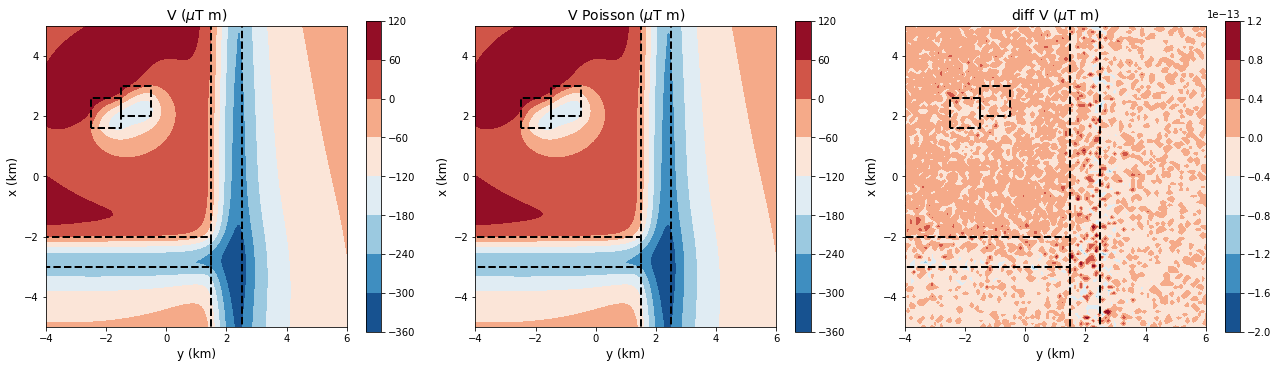

In [10]:
fields = [V, V_Poisson, diff_V]
windows = [1, 2, 3]
titles = ['V ($\mu$T m)', 'V Poisson ($\mu$T m)', 'diff V ($\mu$T m)']

plt.figure(figsize=(18,5))

for w, window in enumerate(windows):

    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()